In [ ]:
#using tensor flow
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
################################## importing all the required libraries

import numpy as np
import pandas as pd
import xlrd
import os
import matplotlib.pyplot as plt
from glob import glob

import librosa as lr
import librosa, librosa.display
import keras
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

Using TensorFlow backend.


In [ ]:
# mounting google drive to google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzipping the audio dataset file (cough audio in wav format) from google audio dataset.
!unzip /content/gdrive/MyDrive/audio1.zip

Archive:  /content/gdrive/MyDrive/audio1.zip
mapname:  conversion of  failed
 extracting: pos-0421-087-cough-f-40.wav  
 extracting: pos-0421-094-cough-m-51.wav  
 extracting: pos-0421-084-cough-m-50.wav  
 extracting: pos-0422-096-cough-m-31.wav  
 extracting: pos-0421-092-cough-m-53.wav  
 extracting: pos-0421-086-cough-m-65.wav  
 extracting: pos-0421-093-cough-f-24.wav  
 extracting: scNubtTugaY_ 0.000_ 9.000.wav  
 extracting: BP7V4MBMekQ_ 0.000_ 8.000.wav  
 extracting: XD4BKqEoQ48_ 0.000_ 3.000.wav  
 extracting: yLGcTSCePzI_ 0.000_ 7.000.wav  
 extracting: OLSccYz9LW0_ 0.000_ 7.000.wav  
 extracting: 2YF-ValJNas_ 0.000_ 5.000.wav  
 extracting: O6Vf6o4V5-8_ 0.000_ 8.000.wav  
 extracting: jNRq5EwaLn8_ 0.000_ 8.000.wav  
 extracting: F6u-BlaMvRI_ 0.000_ 7.000.wav  
 extracting: bRM1wpEEdgI_ 0.000_ 5.000.wav  
 extracting: -ej81N6Aqo4_ 0.000_ 8.000.wav  
 extracting: QC9481d_cXQ_ 0.000_ 9.000.wav  
 extracting: ZvKn6e1AZCU_ 0.000_ 8.000.wav  
 extracting: NpU2_AfQL-8_ 0.000_ 5.00

In [ ]:
# reading the excel file containing metadata for each audio 
test = pd.read_excel("/content/gdrive/MyDrive/cough_dataset.xlsx")

In [ ]:
# head of excel
test.head()

,cough-shallow-3CwioNQVDBQ6CttLyFVRJpMpVHk2.wav,covid
0,pos-0421-084-cough-m-50.wav,covid
1,cough-heavy-6T43bddKoKfG7MwnJWvrPZSsyrc2.wav,covid
2,cough-heavy-hNAGUEhL2Nh7V89at3yFEjQYo6c2.wav,covid
3,cough-heavy-hte8VptUoGVFEqvHpbh5brgfcNP2.wav,covid
4,cough-shallow-QjBZv868nydJzk0ZzwgKDHSG6Q82.wav,covid


In [ ]:
# tail of excel
test.tail()

,cough-shallow-3CwioNQVDBQ6CttLyFVRJpMpVHk2.wav,covid
743,6lbkx_tf50g_ 220.000_ 230.000.wav,not_covid
744,KoUw2T0QKgY_ 70.000_ 80.000.wav,not_covid
745,X0kpF1at8lM_ 0.000_ 10.000.wav,not_covid
746,j7MwYU5VH1s_ 70.000_ 80.000.wav,not_covid
747,o-TJISpYLFc_ 50.000_ 60.000.wav,not_covid


In [ ]:
# defining the length and width of image
IMG_LENGTH = 1025//2
IMG_WIDTH = 1290//2

In [ ]:
# prepared a function which converts audio files to log spectrogram. Takes input as .wav(audio) and outputs it in spectrogram (image).

def read_wav(path):
    signal, sample_rate = librosa.load(path, sr=22050)
    
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    # perform stft
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)
    
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    #MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    #S=librosa.feature.melspectrogram(y=signal, sr=22050, n_mels=128, fmax=22050/2)
    return log_spectrogram

In [ ]:
# creating 2 seperate lists, one for healthy data and other for covid positive data
dataset_healthy = []
dataset_positive = []
max_width = 0
base_path = "/content"

for i in test.to_numpy():
    path = base_path + "/" + i[0] 
    if i[1] == 'not_covid':
      dataset_healthy.append(read_wav(path))
      max_width = max(max_width, dataset_healthy[-1].shape[1])
    else:
      dataset_positive.append(read_wav(path))
      max_width = max(max_width, dataset_positive[-1].shape[1])

In [ ]:
#unzipping zip file containing data from coswara database
!unzip /content/gdrive/MyDrive/covid1.zip

Archive:  /content/gdrive/MyDrive/covid1.zip
   creating: covid1/0pqMnxeSybfQnGV9nHW3P69FSzE3/
  inflating: covid1/0pqMnxeSybfQnGV9nHW3P69FSzE3/cough-heavy.wav  
  inflating: covid1/0pqMnxeSybfQnGV9nHW3P69FSzE3/metadata.json  
   creating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/breathing-deep.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/breathing-shallow.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/cough-heavy.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/cough-shallow.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/counting-fast.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/counting-normal.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/metadata.json  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/vowel-a.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/vowel-e.wav  
  inflating: covid1/139P5XQHCAPJlxTo53QLd6FviL82/vowel-o.wav  
   creating: covid1/19TcpGAeIyeLxS55XA6xxH285uz2/


In [ ]:
#reading excel for the dataset
test1 = pd.read_excel("/content/gdrive/MyDrive/covid1999.xlsx")

In [ ]:
# tail of excel
test1.tail()

,id,a,cold,record_date,cough,covid_status,ctScan,dT,ep,fV,fever,ftg,g,l_c,l_l,l_s,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
125,NVzhTN4CXebH2lQVFkBTyl6ue5h2,NaN,68,NaN,2021-06-28 00:00:00,positive_moderate,web,n,2,female,NaN,India,Coimbatore,Tamil Nadu,n,n,rtpcr,2021-06-25 00:00:00,p,y,n,NaN,NaN,True,NaN,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
126,lpohIzcDNEg3DR38ku43WHiCkC42,NaN,62,NaN,2021-06-28 00:00:00,positive_moderate,web,n,2,male,NaN,India,Coimbatore,Tamil Nadu,n,n,rtpcr,2021-06-20 00:00:00,p,n,n,NaN,NaN,True,NaN,True,True,NaN,NaN,NaN,NaN,2021-06-25 00:00:00,9,NaN,NaN,NaN,NaN
127,xgdd8l7OfrMOkvrskW5s6fxk3mg2,NaN,68,NaN,2021-06-28 00:00:00,positive_mild,web,n,2,female,True,India,Coimbatore,Tamil Nadu,n,n,rtpcr,2021-06-24 00:00:00,p,y,p,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
128,Iz9X0QRimVT2R7AGhD6jZM0ryPp1,NaN,20,NaN,2021-06-28 00:00:00,positive_mild,web,y,2,female,NaN,India,Coimbatore,Tamil Nadu,n,n,rtpcr,2021-06-26 00:00:00,p,y,n,True,True,True,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,BT453L7uDzL5IH0BOlDRJhWZWEL2,NaN,57,NaN,2021-06-28 00:00:00,positive_moderate,web,n,2,female,True,India,Coimbatore,Tamil Nadu,n,n,rtpcr,2021-06-22 00:00:00,p,n,n,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# converting coswara data audio files to spectrogram and appending to the healthy and positive list
base_path1 = "/content/covid1"

for i in test1.to_numpy():
    path = base_path1 + "/" + i[0] + '/cough-heavy.wav'
    print(path)
    if i[5] == 'healthy':
      dataset_healthy.append(read_wav(path))
      max_width = max(max_width, dataset_healthy[-1].shape[1])
    else:
      dataset_positive.append(read_wav(path))
      max_width = max(max_width, dataset_positive[-1].shape[1])

/content/covid1/cQEUPCFkSBfwuTsWap02ban51g82/cough-heavy.wav
/content/covid1/CRrk6OagJdebILgQWEGKDZXzi7z1/cough-heavy.wav
/content/covid1/j8snVeVNX8arLjDPnD9NGjL7MLD3/cough-heavy.wav
/content/covid1/qyoosYbdlucXoQ1cKkN9wzV6vru2/cough-heavy.wav
/content/covid1/hCix5UmABWZVW40elRFgkGabPa52/cough-heavy.wav
/content/covid1/pTWb2MrlwEVwkDAQkOFb1uh5Ddy2/cough-heavy.wav
/content/covid1/2p5hBaoMtUZmVVEH3uJLvGbe9cB3/cough-heavy.wav
/content/covid1/fnNx5YGGVbZ4H8HtWucxTmQlt7y1/cough-heavy.wav
/content/covid1/6yut3EO9tXPCCY8O0VDWA5PCWYN2/cough-heavy.wav
/content/covid1/8EVaH2QxukMhhg0ALCubXVa3Bsl2/cough-heavy.wav
/content/covid1/lRsw8buO7jQSHGzSWIOPW5JboM82/cough-heavy.wav
/content/covid1/DT3eTAupOCRU40MK7cj8ZhzCoB53/cough-heavy.wav
/content/covid1/D9EEvq1ksqN6PEWzIAy7Mu5e8jJ3/cough-heavy.wav
/content/covid1/uAEOVPr487bFnks4dvytsxJQZP02/cough-heavy.wav
/content/covid1/RmWwhKI8kjPi5qN9H740rfm0jHA2/cough-heavy.wav
/content/covid1/sgYoFXPJ01ekO1Fa1ePU5OsiWda2/cough-heavy.wav
/content/covid1/EnEYPaPT

In [ ]:
# creating data split (splitting data into train and validation dataset) train = 75%  and validation =25%

X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(dataset_healthy, [[1, 0] for i in range(len(dataset_healthy))], test_size=0.25)
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(dataset_positive, [[0, 1] for i in range(len(dataset_positive))], test_size=0.25)

In [ ]:
#Preparing X_train, y_train , X_test and y_test .
# also implementing data shuffling. 

X_train = X_train_positive + X_train_healthy
y_train = y_train_positive + y_train_healthy
X_test = X_test_positive + X_test_healthy
y_test = y_test_positive + y_test_healthy
print(len(X_train), len(X_test))
X_train,y_train = shuffle(X_train,y_train)
X_test,y_test = shuffle(X_test,y_test)

658 220


In [ ]:
# preparing a norm function which is used to normalize data by the help of padding and prepares all the images of equal length.

def norm(data):
  normalized_dataset_X = []
  for img in data:
      padding = (max_width - img.shape[1])//2
      normalized_dataset_X.append(cv2.resize(np.pad(img, ((0, 0), (padding, max_width - padding - img.shape[1]))), dsize=(IMG_LENGTH, IMG_WIDTH)))
  return normalized_dataset_X

In [ ]:
#applying norm function on the train and test dataset.

X_train = np.array(norm(X_train)).reshape(-1, IMG_LENGTH, IMG_WIDTH, 1)
X_test = np.array(norm(X_test)).reshape(-1, IMG_LENGTH, IMG_WIDTH, 1)
y_train = np.array(y_train)
y_test = np.array(y_test) 

In [ ]:
# preparing keras model of Conv2D. Using CNN model with 5 layers and applying Batch normalization and Maxpooling for refined output at each step.

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3, 3), activation="relu", input_shape = (IMG_LENGTH, IMG_WIDTH, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

In [ ]:
# applying flatten and dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2048, activation="relu"))

In [ ]:
# setting the droupout value for the model to be 0.3
model.add(keras.layers.Dropout(0.3))

In [ ]:
model.add(keras.layers.Dense(2, activation = "softmax"))

In [ ]:
# compiling and preparing the model. Using Adam optimizer.
model.compile(optimizer = keras.optimizers.Adam(1e-6), loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 510, 643, 8)       80        
_________________________________________________________________
batch_normalization_6 (Batch (None, 510, 643, 8)       32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 255, 321, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 253, 319, 16)      1168      
_________________________________________________________________
batch_normalization_7 (Batch (None, 253, 319, 16)      64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 126, 159, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 157, 32)     

In [ ]:
# training the model on 658 samples and validating the data on 220 samples

model.fit(X_train, y_train, epochs=50,batch_size=64, validation_data=(X_test, y_test))

Train on 658 samples, validate on 220 samples
Epoch 1/50
658/658 [==============================] - 9s 14ms/step - loss: 0.9153 - accuracy: 0.6687 - val_loss: 0.5709 - val_accuracy: 0.8318
Epoch 2/50
658/658 [==============================] - 9s 13ms/step - loss: 0.3963 - accuracy: 0.8587 - val_loss: 0.6738 - val_accuracy: 0.6091
Epoch 3/50
658/658 [==============================] - 8s 13ms/step - loss: 0.2383 - accuracy: 0.8951 - val_loss: 0.5307 - val_accuracy: 0.8545
Epoch 4/50
658/658 [==============================] - 9s 13ms/step - loss: 0.1897 - accuracy: 0.9407 - val_loss: 0.4792 - val_accuracy: 0.8500
Epoch 5/50
658/658 [==============================] - 9s 13ms/step - loss: 0.1341 - accuracy: 0.9605 - val_loss: 0.4408 - val_accuracy: 0.8455
Epoch 6/50
658/658 [==============================] - 9s 13ms/step - loss: 0.1217 - accuracy: 0.9574 - val_loss: 0.4141 - val_accuracy: 0.8455
Epoch 7/50
658/658 [==============================] - 9s 13ms/step - loss: 0.0953 - accuracy: 0.

In [ ]:
predict= model.predict(X_test)

In [ ]:
# preparing and printing final predictions by the model
final_predictions = [np.argmax(i) for i in predict]
print(final_predictions)

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]


In [ ]:
# printing the actual values given to the model
print([np.argmax(i) for i in y_test])

[1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]


In [ ]:
y_pred = np.argmax(predict, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion matrix
[[182   1]
 [  3  34]]


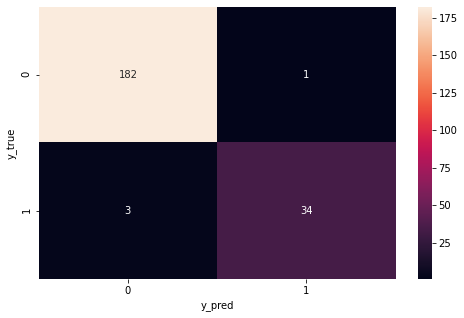

In [ ]:
# importing libraries to prepare a confusion matrix and plotting it.

from sklearn.metrics import confusion_matrix
import seaborn as sns
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# importing libraries and plotting a roc curve

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
y_test_kears= y_test.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_kears, y_pred_keras)

In [ ]:
# calculating auc values
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

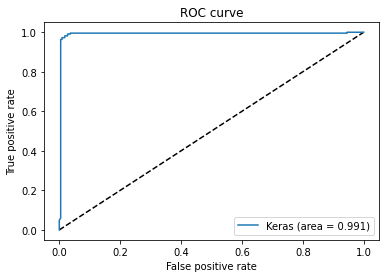

In [ ]:
# plotting roc curve.

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(confusion_matrix(y_true, y_pred))

True Positives: 34
True Negatives: 182
False Positives: 1
False Negatives: 3
--------------------------------------------------
Accuracy: 0.98
Mis-Classification: 0.02
Sensitivity: 0.92
Specificity: 0.99
Precision: 0.99
f_1 Score: 0.96
